<a href="https://colab.research.google.com/github/ZefraAlseif/Predicting-ELectric-Load/blob/main/One_Input_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
#from common.utils import load_data, extract_data, download_file %matplotlib inline
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers
import copy

# Import zip folder

In [ ]:
!wget https://mlftsfwp.blob.core.windows.net/mlftsfwp/GEFCom2014.zip

--2022-04-27 19:48:59--  https://mlftsfwp.blob.core.windows.net/mlftsfwp/GEFCom2014.zip
Resolving mlftsfwp.blob.core.windows.net (mlftsfwp.blob.core.windows.net)... 52.239.155.196
Connecting to mlftsfwp.blob.core.windows.net (mlftsfwp.blob.core.windows.net)|52.239.155.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126360077 (121M) [application/x-zip-compressed]
Saving to: ‘GEFCom2014.zip’

GEFCom2014.zip      100%[===================>] 120.51M  9.49MB/s    in 11s     

2022-04-27 19:49:11 (11.2 MB/s) - ‘GEFCom2014.zip’ saved [126360077/126360077]



# Unzip Folder

In [ ]:
!unzip GEFCom2014.zip

Archive:  GEFCom2014.zip
   creating: GEFCom2014 Data/
 extracting: GEFCom2014 Data/GEFCom2014-S_V2.zip  
 extracting: GEFCom2014 Data/GEFCom2014-W_V2.zip  
  inflating: GEFCom2014 Data/READ ME_V2.txt  
  inflating: GEFCom2014 Data/Provisional_Leaderboard_V2.xlsx  
 extracting: GEFCom2014 Data/GEFCom2014-L_V2.zip  
 extracting: GEFCom2014 Data/GEFCom2014-E_V2.zip  
 extracting: GEFCom2014 Data/GEFCom2014-P_V2.zip  


# Unzip 2nd Folder

In [ ]:
!mv 'GEFCom2014 Data'/GEFCom2014-E_V2.zip ./
!unzip GEFCom2014-E_V2.zip

Archive:  GEFCom2014-E_V2.zip
  inflating: GEFCom2014-E.xlsx       


# Converting to Pandas Dataframe

In [ ]:
GEFDF = pd.read_excel('GEFCom2014-E.xlsx', skiprows=range(1, 17545), dtype = {'A':np.int32,})

# Writing out GEFDF to text file

In [ ]:
GEFDF.to_csv('GEF14.csv', encoding='utf-8', index=False, header=True, columns=['Hour','load','T'])
with open('GEF14.csv') as f:
  lines = f.readlines()
  last = len(lines) - 1
  lines[last] = lines[last].replace('\r','').replace('\n','')
with open('GEF14.csv', 'w') as wr:
  wr.writelines(lines)

# Inspect the Data

In [ ]:
fname = os.path.join("GEF14.csv")
with open(fname) as f:
  data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['Hour', 'load', 'T']
78888


# Parsing the Data

In [ ]:
eload = np.zeros((len(lines),))
tempf = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header)-2)) #chgd )-1 to )-2 to also
# remove the HOUR column, in addition to the DATE column
print(len(lines))
for m in range(78888):
  thisline = lines[m]
  values = [float(x) for x in thisline.split(",")[1:]]
  eload[m] = values[0] #Captures JUST E LOAD
  tempf[m] = values[1] #Captures JUST TEMPF
  raw_data[m] = values[0] #Like this, raw_data Captures JUST E LOAD
  #raw_data[m, :] = values[:] # Like this, raw_data CAPTURES BOTH

78888


# Plotting the Eload Timeseries

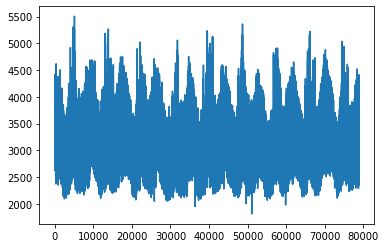

In [ ]:
plt.plot(range(len(eload)), eload)

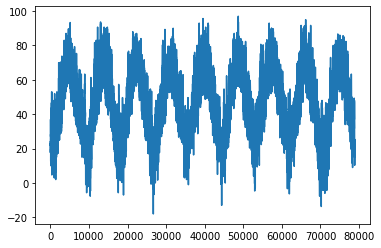

In [ ]:
plt.plot(range(len(tempf)), tempf)

# Number of Samples for each split

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 39444
num_val_samples: 19722
num_test_samples: 19722


# Preparing the Data

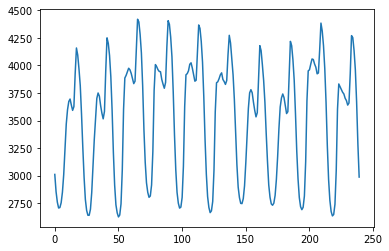

In [ ]:
plt.plot(range(240),eload[:240])

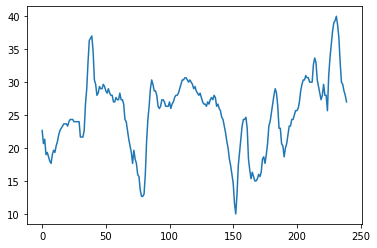

In [ ]:
plt.plot(range(240),tempf[:240])

# Normalizing the Data

In [ ]:
Copy_raw_data = copy.copy(raw_data)
mean = Copy_raw_data[:num_train_samples].mean(axis=0)
Copy_raw_data -= mean
std = Copy_raw_data[:num_train_samples].std(axis=0)
Copy_raw_data /= std

print("Highest value of test set: ",raw_data[num_train_samples + num_val_samples:].max(axis=0))
print("Smallest value of test set: ",raw_data[num_train_samples + num_val_samples:].min(axis=0))
print("Full range of test set: ",raw_data[num_train_samples + num_val_samples:].max(axis=0) - raw_data[num_train_samples + num_val_samples:].min(axis=0))

Highest value of test set:  [5224.]
Smallest value of test set:  [1979.]
Full range of test set:  [3245.]


# Arranging DataSets

In [ ]:
horizon = 6 # Num. of hours ahead for forecast (3 or 6)
sampling_rate = 1
sequence_length = 24 # For horizon = 3 (sequence length < 15) & horizon = 6 (sequence length < 36)
delay = sampling_rate * (sequence_length + horizon - 1)
batch_size = 128
train_dataset = keras.utils.timeseries_dataset_from_array(
Copy_raw_data[:-delay],
targets=Copy_raw_data[delay:], # This would used "Normalized Targets"
# targets=eload[delay:], # This would used "Not-normalized eload targets"
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True, #changed to false JUST FOR VERIF
batch_size= num_train_samples,
start_index=0,
end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
Copy_raw_data[:-delay], # changed from raw_data to just eload not really
targets=Copy_raw_data[delay:], # This would used "Normalized Targets"
# targets=eload[delay:], # This would used "Not-normalized eload targets"
sampling_rate=sampling_rate,
sequence_length=sequence_length, 
shuffle=True,
batch_size=num_val_samples,
start_index=num_train_samples,
end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
Copy_raw_data[:-delay], # changed from raw_data to just eload
targets=Copy_raw_data[delay:], # This would used "Normalized Targets"
# targets=eload[delay:], # This would used "Not-normalized eload targets"
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=False,
batch_size=num_test_samples,
start_index=num_train_samples + num_val_samples)

# Inspecting Output of Datasets

In [ ]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break 

samples shape: (39421, 24, 1)
targets shape: (39421, 1)


# Training and Evaluating

In [ ]:
inputs = keras.Input(shape=(sequence_length, Copy_raw_data.shape[-1]))
x = layers.GRU(50, recurrent_dropout=0.25, return_sequences=True)(inputs)
x = layers.GRU(100, recurrent_dropout=0.15, return_sequences=True)(x)
x = layers.LSTM(32, recurrent_dropout=0.15, return_sequences=True)(x)
x = layers.LSTM(16, recurrent_dropout=0.25) (x)
x = layers.Dropout (.5) (x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
keras.callbacks.ModelCheckpoint("predictor.keras",
save_best_only=True)
]

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=5e-3), loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
epochs=750,
validation_data=val_dataset,
callbacks=callbacks)
model = keras.models.load_model("predictor.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

model.summary()

Epoch 1/750
1/1 [==============================] - 14s 14s/step - loss: 1.0028 - mae: 0.8304 - val_loss: 1.0143 - val_mae: 0.8036
Epoch 2/750
1/1 [==============================] - 4s 4s/step - loss: 1.0066 - mae: 0.8099 - val_loss: 0.8273 - val_mae: 0.7591
Epoch 3/750
1/1 [==============================] - 4s 4s/step - loss: 0.9116 - mae: 0.7938 - val_loss: 0.8561 - val_mae: 0.7433
Epoch 4/750
1/1 [==============================] - 4s 4s/step - loss: 0.9120 - mae: 0.7713 - val_loss: 0.6283 - val_mae: 0.6529
Epoch 5/750
1/1 [==============================] - 4s 4s/step - loss: 0.7107 - mae: 0.6903 - val_loss: 1.3863 - val_mae: 0.9040
Epoch 6/750
1/1 [==============================] - 4s 4s/step - loss: 1.5035 - mae: 0.9602 - val_loss: 0.8350 - val_mae: 0.7559
Epoch 7/750
1/1 [==============================] - 4s 4s/step - loss: 0.8837 - mae: 0.7842 - val_loss: 0.7009 - val_mae: 0.6623
Epoch 8/750
1/1 [==============================] - 4s 4s/step - loss: 0.7470 - mae: 0.6937 - val_loss:

# Plotting Results

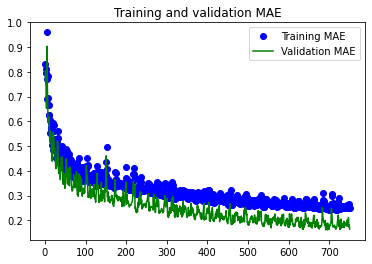

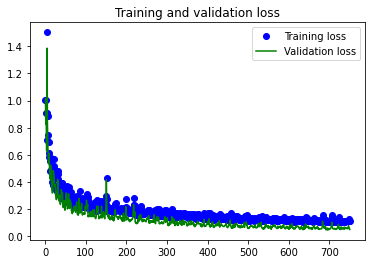

Final Training loss:  0.11105220764875412 
Final Training MAE:  0.2512136399745941
Final Validation loss:  0.05078193545341492 
Final Validation MAE:  0.16434980928897858


In [ ]:
acc = history.history["mae"]
val_acc = history.history["val_mae"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training MAE")
plt.plot(epochs, val_acc, "g", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "g", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()
print("Final Training loss: ",history.history['loss'][-1],"\nFinal Training MAE: ", history.history['mae'][-1])
print("Final Validation loss: ",history.history['val_loss'][-1],"\nFinal Validation MAE: ", history.history['val_mae'][-1])

# Comparing Predictions vs Targets

1/1 [==============================] - 2s 2s/step - loss: 0.0529 - mae: 0.1718


[0.05294589698314667, 0.17182381451129913]

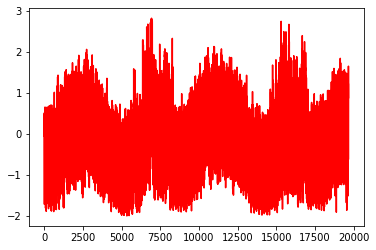

In [ ]:
model = keras.models.load_model("predictor.keras") # bringing the “best model”
predictions = model.predict(test_dataset)
lenpred = len(predictions)
plt.plot(range(lenpred), predictions, 'r')
model.evaluate(test_dataset)

midtargets shape: (19670, 1)


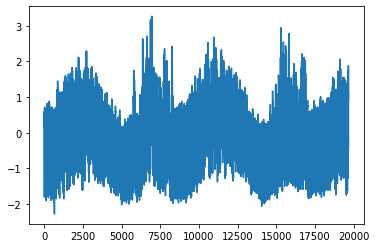

In [ ]:
# Retrieving and "cropping" the original targets
org_targets = Copy_raw_data[num_train_samples + num_val_samples:] # targets for testing
# We notice there are more "original targets" that predictions
# We must "crop" the original targets on the left and on the right
# Applying these left_ & right_ crops yields the midtargets, which
# will be the same size as the predictions. It will possible to
# overlay the 2 complete series or any corresponding parts of them
left_crop = (sequence_length + horizon) * sampling_rate
right_crop = ( (sequence_length - 1) * sampling_rate) - 1
midtargets = org_targets[left_crop:-right_crop]
print("midtargets shape:", midtargets.shape)
plt.plot(range(len(midtargets)), midtargets)
# THIS IS IS THE PLOT OF SCALED-DOWN (NORMALIZED) TARGETS FOR THE TEST SET

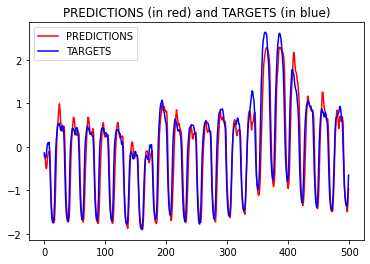

In [ ]:
# Now overlay plot of predictions and targets in the same interval
plt.plot(predictions[6000:6500], "r", label="PREDICTIONS")
plt.plot(midtargets[6000:6500], "b", label="TARGETS")
plt.title("PREDICTIONS (in red) and TARGETS (in blue)")
plt.legend()
plt.show()

# Denormalizing Data

(19670,)
(19670,)


<function matplotlib.pyplot.show>

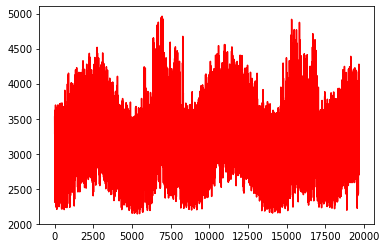

In [ ]:
# De normalizing the data
EFFpredictions1 = np.asarray(predictions * std)
EFFpredictions2 = EFFpredictions1.flatten()

MEANV = (np.ones(lenpred,)) * mean

EFFpredictions = EFFpredictions2 + MEANV
print(EFFpredictions.shape)

EFFmidtargets1 = np.asarray(midtargets * std)
EFFmidtargets2 = EFFmidtargets1.flatten()

MEANV = (np.ones(lenpred,)) * mean

EFFmidtargets = EFFmidtargets2 + MEANV
print(EFFpredictions.shape)

plt.plot(range(lenpred), EFFpredictions, 'r')
plt.show

<function matplotlib.pyplot.show>

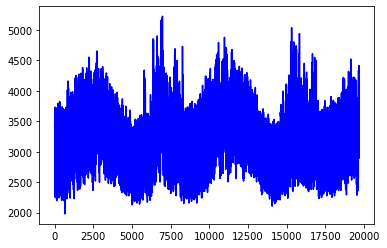

In [ ]:
plt.plot(range(lenpred), EFFmidtargets, 'b')
plt.show

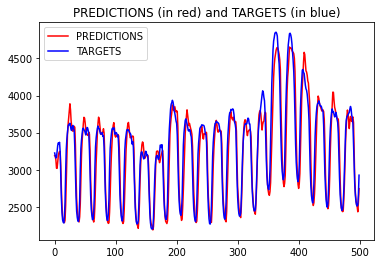

In [ ]:
plt.plot(EFFpredictions[6000:6500], "r", label="PREDICTIONS")
plt.plot(EFFmidtargets[6000:6500], "b", label="TARGETS")
plt.title("PREDICTIONS (in red) and TARGETS (in blue)")
plt.legend()
plt.show()

In [ ]:
EFFECTIVE_MAE = np.mean(np.abs(EFFpredictions - EFFmidtargets))
print(f'EFFECTIVE real-scale MAE: {EFFECTIVE_MAE:.2f}')
PMAE = (EFFECTIVE_MAE /  (EFFmidtargets.max() - EFFmidtargets.min())) * 100
print(PMAE)

EFFECTIVE real-scale MAE: 169.55
5.224982928952527
